# Processing with Dask

<div>
    <img style='width: 220px;height: 100px;float: left;' src="./Supplementary_data/EODC-Logo-Final.png" height='100px' width='220px'/>
    <img style='width: 200px;height: 100px;float: left;' src="./Supplementary_data/BMNT_DE_Logo_dreizeilig_srgb.svg" height='100px' width='200px'/> 
    <img style='width: 200px;height: 100px;float: left;' src="./Supplementary_data/bmlv.svg" height='100px' width='200px'/>
    <img style='width: 200px;height: 100px;float: left;' src="./Supplementary_data/LOGO_TUW_GEO.png" height='100px' width='200px'/>
    <img style='width: 100px;height: 100px;float: left;' src="./Supplementary_data/Boku-wien.svg" height='100px' width='100px'/>
    <img style='width: 150px;height: 100px;float: right;' src="./Supplementary_data/ADC_Logo_final_transparent.png" height='100px' width='150px'/>
</div>

This notebook outlines working with `Dask` for big data. Dask enables paralelization and working with bigger amounts of data than shown in previous examples. In this notebook a resample will be computed on 3 years for a product.

## Initialization and imports

To initialize a connection to the cluster, along with standard imports, we import the `Client` class from the `dask.distributed` module. The cluster is currently available at: tcp://10.250.19.87:8786, so that is provided as an attribute.

In [1]:
from dask.distributed import Client
import datacube
import xarray
from pprint import pprint
%matplotlib inline
dc = datacube.Datacube(app='sample_fapar', env='acube')
product = 'FAPAR_Sentinel_2'
client = Client('tcp://10.250.19.87:8786')

In [2]:
client

Client Scheduler: tcp://10.250.19.87:8786 Dashboard: http://10.250.19.87:8787/status,Cluster Workers: 3 Cores: 12 Memory: 37.77 GB


## Searching for products

Searching remains the same as the previous example. Here we use the `FAPAR_Sentinel_2` product.

In [3]:
prodlist=dc.list_products().dropna(axis=1)
prodlist[prodlist['name'] == product]

,name,description,format,instrument,product_type,platform,crs,resolution,spatial_dimensions
id,,,,,,,,,
10,FAPAR_Sentinel_2,Fraction of Photosynthetically Active Radiation,GeoTIFF,MSI,BOKU_FAPAR_S2,Sentinel-2,"PROJCS[""unnamed"",GEOGCS[""WGS 84"",DATUM[""WGS_19...","(-10, 10)","(y, x)"


In [4]:
measlist = dc.list_measurements()
measlist.loc[measlist.index.get_level_values(0) == product]

,,name,dtype,units,nodata,aliases
product,measurement,,,,,
FAPAR_Sentinel_2,band_1,band_1,int16,fraction,32767,"[band_01, Band1, Band_1]"


In [5]:
query = {
    'lat': (48.15, 48.35),
    'lon': (16.3, 16.5),
    'time': ('2016-01-01', '2020-01-10')
}

## Data Loading

To load data lazily we use the `dask_chunks` argument, and specify the number of x,y pixels and time slices that represent a single chunk for computation. These values might need to be modified for faster results. The array `band_1` is actually a `numpy` array but here it loads as a lazy `dask.array` meaning no loading is taking place.

In [6]:
data = dc.load(product=product, 
               output_crs='EPSG:32633', 
               resolution=(-10,10),
               dask_chunks={'x':1000, 'y':1000, 'time':30},
                **query)
data

<xarray.Dataset>
Dimensions:      (time: 369, x: 1526, y: 2250)
Coordinates:
  * time         (time) datetime64[ns] 2017-01-01 2017-01-04 ... 2020-01-08
  * y            (y) float64 5.356e+06 5.356e+06 ... 5.334e+06 5.334e+06
  * x            (x) float64 5.963e+05 5.963e+05 ... 6.116e+05 6.116e+05
    spatial_ref  int32 32633
Data variables:
    band_1       (time, y, x) int16 dask.array<chunksize=(30, 1000, 1000), meta=np.ndarray>
Attributes:
    crs:           EPSG:32633
    grid_mapping:  spatial_ref

In [7]:
arr=data.band_1

## Resampling and computation

Resampling is necessary when you’re given a data set recorded in some time interval and you want to change the time interval to something else. For example, you could aggregate monthly data into yearly data, or you could upsample hourly data into minute-by-minute data. In this example the temporal resolution is resampled to a month by computing the average using `resample()` and `mean()` methods.

In [8]:
resampled = arr.resample(time='1m').mean().mean(axis=(1,2))
resampled

<xarray.DataArray 'band_1' (time: 37)>
dask.array<mean_agg-aggregate, shape=(37,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 2017-01-31 2017-02-28 ... 2020-01-31
    spatial_ref  int32 32633

The last step is to call the `compute()` method on the array to trigger computation on the cluster.

CPU times: user 1.15 s, sys: 65.8 ms, total: 1.22 s
Wall time: 35.8 s


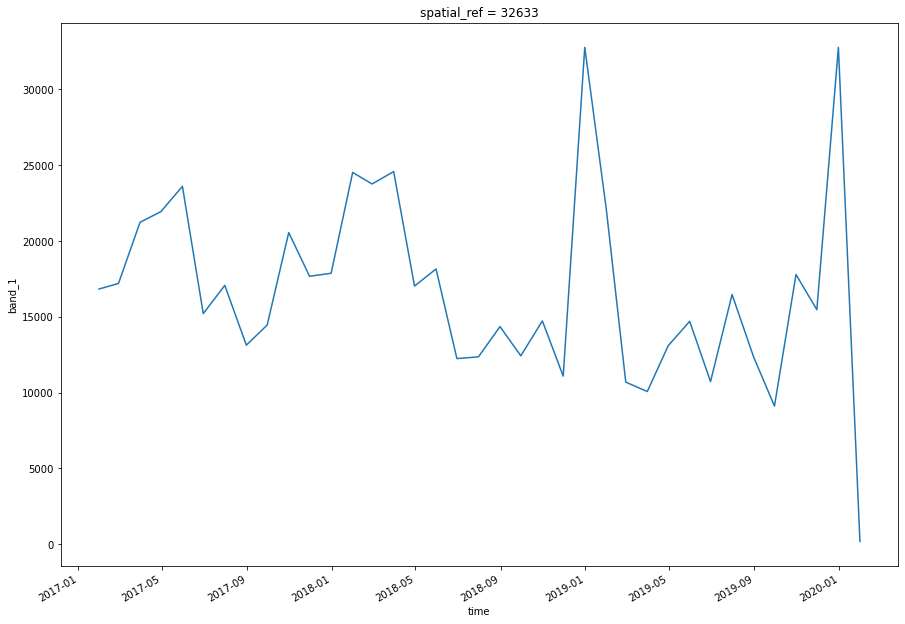

In [9]:
%%time
resampled.compute().plot(size=10)